In [1]:
from vacation.model import VCNN
from vacation.data import GalaxyDataset
import torch
from torchinfo import summary

In [2]:
train_ds = GalaxyDataset(
    path="../../.data/Galaxy10_DECals_train.h5",
    device="cuda",
    max_cache_size="6G",
    cache_loaded=True,
)

In [2]:
valid_ds = GalaxyDataset(
    path="../../.data/Galaxy10_DECals_valid.h5",
    device="cuda",
    max_cache_size="6G",
    cache_loaded=True,
)

In [3]:
model = VCNN(
    img_size=256,
    num_labels=10,
    train_batch_size=256,
    valid_batch_size=256,
    out_channels=[4, 8, 10],
    dropout_rates=[0, 0, 0],
    lin_out_features=[300, 100],
    optimizer=torch.optim.AdamW,
    activation_func=torch.nn.PReLU,
    learning_rate=0.005,
    loss_func=torch.nn.CrossEntropyLoss,
)

In [16]:
model.train_epochs(n_epochs=20, train_dataset=train_ds, valid_dataset=valid_ds)

Training epoch 1:   0%|          | 0/17 [00:00<?, ?it/s]

Validating epoch 1:   0%|          | 0/17 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/17 [00:00<?, ?it/s]

Validating epoch 2:   0%|          | 0/17 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/17 [00:00<?, ?it/s]

Validating epoch 3:   0%|          | 0/17 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/17 [00:00<?, ?it/s]

Validating epoch 4:   0%|          | 0/17 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/17 [00:00<?, ?it/s]

Validating epoch 5:   0%|          | 0/17 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/17 [00:00<?, ?it/s]

Validating epoch 6:   0%|          | 0/17 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/17 [00:00<?, ?it/s]

Validating epoch 7:   0%|          | 0/17 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/17 [00:00<?, ?it/s]

Validating epoch 8:   0%|          | 0/17 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/17 [00:00<?, ?it/s]

Validating epoch 9:   0%|          | 0/17 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/17 [00:00<?, ?it/s]

Validating epoch 10:   0%|          | 0/17 [00:00<?, ?it/s]

In [5]:
model._loss_metric

Metric(_func=None, func_args=({},), train_vals=tensor([2.2645, 2.0254]), valid_vals=tensor([2.1315, 2.0230]))

In [ ]:
summary(model, (3, 256, 256))

In [9]:
import matplotlib.pyplot as plt

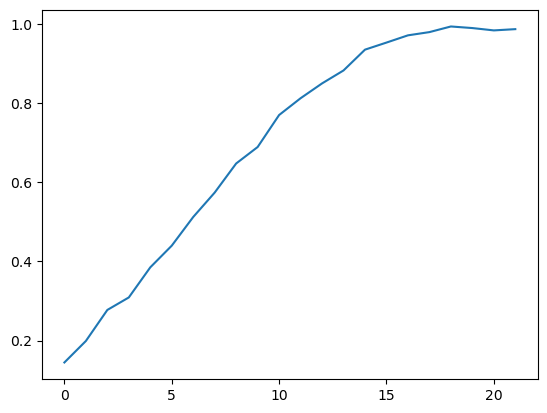

In [17]:
plt.plot(model._metrics["accuracy"].train_vals)

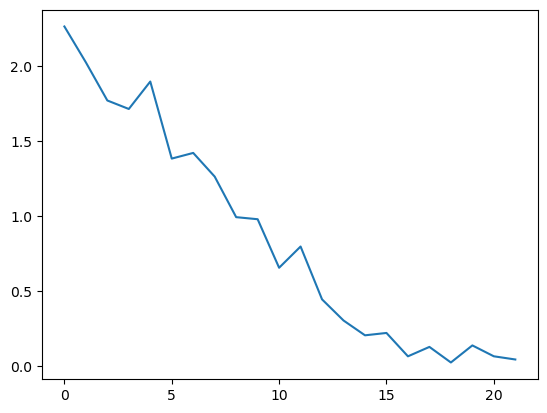

In [18]:
plt.plot(model._loss_metric.train_vals)